In [18]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# plotting params
%matplotlib inline
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['figure.figsize'] = (8.0, 8.0)

plot_dir = '/Users/kevin/Desktop/DRAW/plots/'
data_dir = '/Users/kevin/Desktop/DRAW/data/'

In [19]:
torch.manual_seed(423212)

## Auto-Encoder

We'll start with the simplest autoencoder: a single, fully-connected layer as the encoder and decoder.

In [33]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded

class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DeepAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, encoding_dim), 
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, input_dim),
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [34]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
                    batch_size=10, shuffle=False)

In [36]:
input_dim = 784
encoding_dim = 32

# model = AutoEncoder(input_dim, encoding_dim)
model = DeepAutoEncoder(input_dim, encoding_dim)
optimizer = optim.Adam(model.parameters())

In [37]:
def train(epoch, mse=True):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data.view([-1, 784]))
        optimizer.zero_grad()
        output = model(data)
        if mse:
            loss = F.mse_loss(output, data)
        else:
            loss = F.binary_cross_entropy_with_logits(output, data)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

In [38]:
num_epochs = 50
mse = True

for epoch in range(1,  num_epochs + 1):
    train(epoch, mse)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.032604
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.639298
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.476348
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.427527
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.357932
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.340205
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.330978
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.308315
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.307986
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.287580
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.295089
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.273982
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.265348
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.269491
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.257486
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.262185
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.257531
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.242001
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.239505
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.234455
Train Epoch:

KeyboardInterrupt: 

In [25]:
# encode and decode the test set
data, _ = next(iter(test_loader))
data = Variable(data.view([-1, 784]), volatile=True)
true_imgs = data
encoded_imgs = F.relu(model.encoder(data))
decoded_imgs = model.decoder(encoded_imgs)

In [26]:
def to_img(x):
    x = x.data.numpy()
    x = x.reshape([-1, 28, 28])
    return x

true_imgs = to_img(true_imgs)
decoded_imgs = to_img(decoded_imgs)

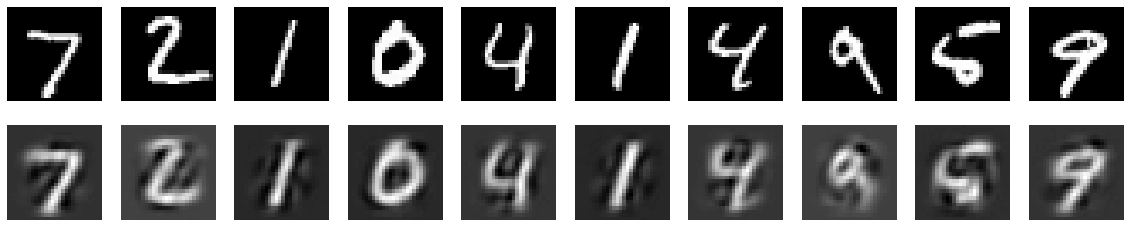

In [27]:
n = 10

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(true_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()